In [9]:
import os
import cv2
import random
import time
import json
from PIL import Image
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
plt.rcParams['axes.grid'] = False

In [216]:
dataset_path  = '../data'
anns_file_path = dataset_path + '/' + 'train_all_new.json'
valid_file_path = dataset_path + '/' + 'val.json'
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
with open(valid_file_path, 'r') as f:
    valid_dataset = json.loads(f.read())

In [248]:
# 이미지 시각화
def showimg(img_id,data='train_all',size=6):
    if data == 'train_all':
        img_path = '../data/' + dataset['images'][img_id]['file_name']
    elif data == 'valid':
        img_path = '../data/' + valid_dataset['images'][img_id]['file_name']
    image = Image.open(img_path)
    plt.figure(figsize=(size,size))
    plt.imshow(image)
    plt.show()

# annotation 시각화
def show_anno(anno_id,seg_id,showbox=True,size=4):
    t = torch.zeros(512,512)
    for i in range(0,len(anns[anno_id]['segmentation'][seg_id]),2):
        t[anns[anno_id]['segmentation'][seg_id][i+1]][anns[anno_id]['segmentation'][seg_id][i]] = anns[anno_id]['category_id']
    if showbox:
        x,y,w,h = anns[anno_id]['bbox']
        for i in range(int(x),int(x+w)):
            t[int(y)][i] = 10
            t[int(y+h)][i] = 10
        for i in range(int(y),int(y+h)):
            t[i][int(x)] = 10
            t[i][int(x+w)] = 10
    plt.figure(figsize=(size,size))
    plt.imshow(t)

def show_annos(anno_id,showbox=True,size=4):
    t = torch.zeros(512,512)
    for s in range(len(anns[anno_id]['segmentation'])):
        for i in range(0,len(anns[anno_id]['segmentation'][s]),2):
            t[anns[anno_id]['segmentation'][s][i+1]][anns[anno_id]['segmentation'][s][i]] = anns[anno_id]['category_id']
    if showbox:
        x,y,w,h = anns[anno_id]['bbox']
        for i in range(int(x),int(x+w)):
            t[int(y)][i] = 10
            t[int(y+h)][i] = 10
        for i in range(int(y),int(y+h)):
            t[i][int(x)] = 10
            t[i][int(x+w)] = 10
    plt.figure(figsize=(size,size))
    plt.imshow(t) 

In [217]:
data = pd.DataFrame(columns = ['image_id','category_id','area','num_seg'])
for i in range(len(dataset['annotations'])):
    image_id = dataset['annotations'][i]['image_id']
    category_id = dataset['annotations'][i]['category_id']
    area = dataset['annotations'][i]['area']
    num_seg = len(dataset['annotations'][i]['segmentation'])
    data.loc[i] = [image_id, category_id, area, num_seg]

valid_data = pd.DataFrame(columns = ['image_id','category_id','area','num_seg'])
for i in range(len(valid_dataset['annotations'])):
    image_id = valid_dataset['annotations'][i]['image_id']
    category_id = valid_dataset['annotations'][i]['category_id']
    area = valid_dataset['annotations'][i]['area']
    num_seg = len(valid_dataset['annotations'][i]['segmentation'])
    valid_data.loc[i] = [image_id, category_id, area, num_seg]

In [218]:
data.tail()

,image_id,category_id,area,num_seg
26926,3466.0,2.0,4672.0,1.0
26927,3466.0,6.0,6968.0,1.0
26928,3466.0,6.0,32018.0,1.0
26929,3466.0,8.0,19037.5,1.0
26930,3466.0,2.0,22343.5,1.0


전체 이미지 개수: 3467

전체 annotation 개수: 26931 / 이미지당 평균: 7.76

In [243]:
valid_data.tail()

,image_id,category_id,area,num_seg
5247,654.0,2.0,10001.0,4.0
5248,654.0,2.0,7899.0,1.0
5249,654.0,2.0,9.5,5.0
5250,654.0,8.0,2536.5,1.0
5251,654.0,2.0,3920.0,1.0


valid 이미지 개수: 655

valid annotation 개수: 5252 / 이미지당 평균: 8.02

### 1. Number of objects per image

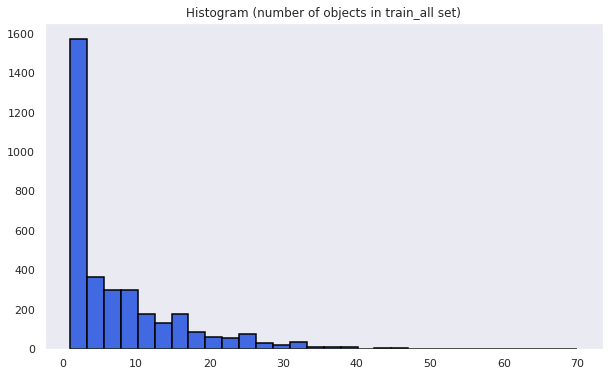

In [226]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(data['image_id'].value_counts(),bins=30,edgecolor='black',linewidth=1.5,color='royalblue')
ax.set_title('Histogram (number of objects in train_all set)')
plt.show()

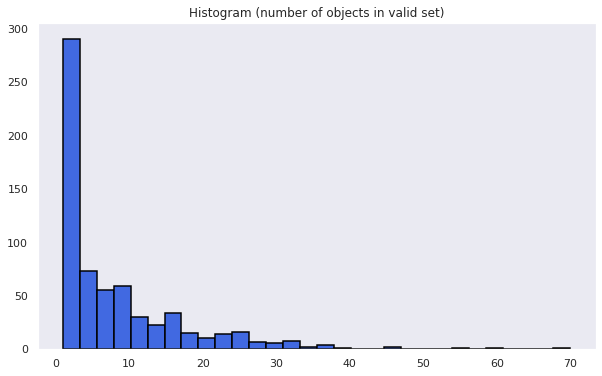

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(valid_data['image_id'].value_counts(),bins=30,edgecolor='black',linewidth=1.5,color='royalblue')
ax.set_title('Histogram (number of objects in valid set)')
plt.show()

### 2. category

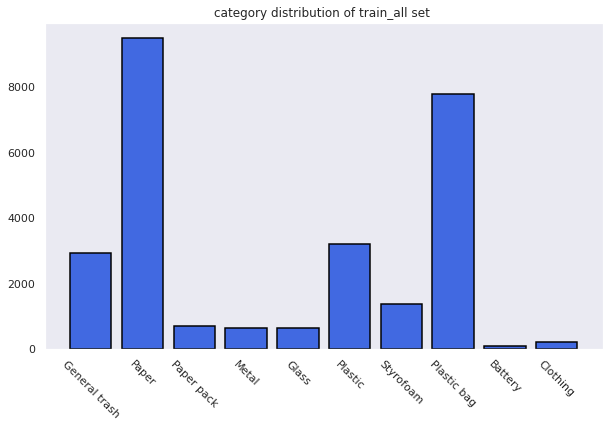

In [222]:
category = [{'id': 1, 'name': 'General trash'},{'id': 2, 'name': 'Paper'},{'id': 3, 'name': 'Paper pack'},{'id': 4, 'name': 'Metal'},{'id': 5, 'name': 'Glass'},
 {'id': 6, 'name': 'Plastic'},{'id': 7, 'name': 'Styrofoam'},{'id': 8, 'name': 'Plastic bag'},{'id': 9, 'name': 'Battery'},{'id': 10, 'name': 'Clothing'}]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(x=data['category_id'].value_counts().index, height=data['category_id'].value_counts().values,edgecolor='black',linewidth=1.5,color='royalblue')
ax.set_xticks([x for x in range(1,11)])
ax.set_xticklabels([category[x]['name'] for x in range(10)],rotation=-45)
ax.set_title("category distribution of train_all set ")
plt.show()

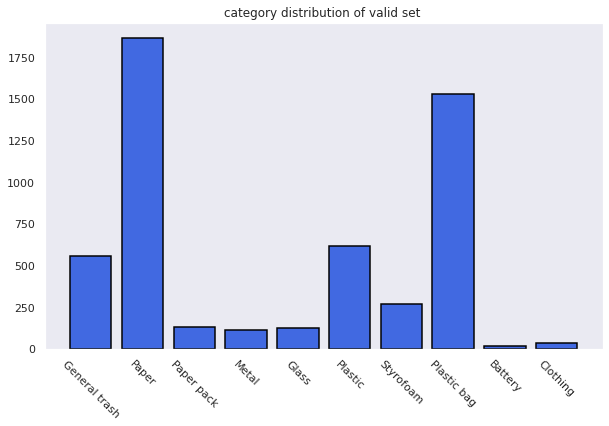

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(x=valid_data['category_id'].value_counts().index, height=valid_data['category_id'].value_counts().values,edgecolor='black',linewidth=1.5,color='royalblue')
ax.set_xticks([x for x in range(1,11)])
ax.set_xticklabels([category[x]['name'] for x in range(10)],rotation=-45)
ax.set_title("category distribution of valid set ")
plt.show()

In [223]:
# train_all set에서 battery에 해당하는 annotation은 70건, battery를 포함하는 이미지는 총 22장
print(len(data[data['category_id'] == 9]))
print(len(data[data['category_id'] == 9]['image_id'].unique()))

# valid set에서 battery에 해당하는 annotation은 13건, battery를 포함하는 이미지는 총 2장
print(len(valid_data[valid_data['category_id'] == 9]))
print(len(valid_data[valid_data['category_id'] == 9]['image_id'].unique()))

70
22
13
2


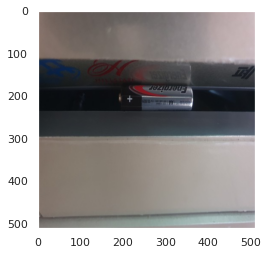

In [253]:
showimg(19,data='valid',size=4)

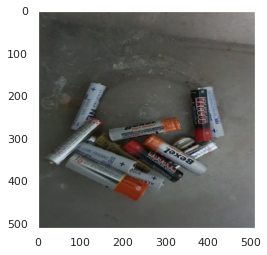

In [256]:
showimg(638,data='valid',size=4)

#### 2-1. number of segmentations

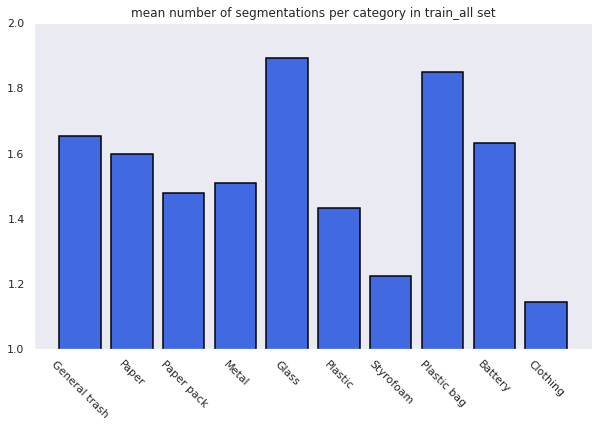

In [228]:
# 1.0에 가까울수록 겹치는 부분이 적고, 값이 클수록 다른 물체와 겹쳐서 영역이 나뉘는 부분이 많음 (아래 3. Annotation 시각화 참고)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(x=data['category_id'].value_counts().index, height=data['num_seg'].groupby(data['category_id']).mean(),edgecolor='black',linewidth=1.5,color='royalblue')
ax.set_xticks([x for x in range(1,11)])
ax.set_ylim((1.0,2.0))
ax.set_xticklabels([category[x]['name'] for x in range(10)],rotation=-45)
ax.set_title("mean number of segmentations per category in train_all set")
plt.show()

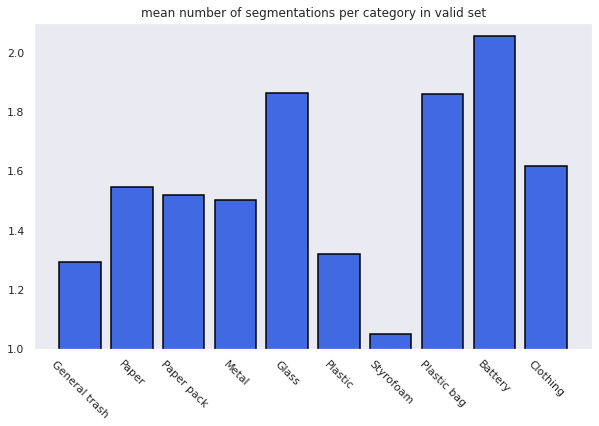

In [257]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(x=valid_data['category_id'].value_counts().index, height=valid_data['num_seg'].groupby(valid_data['category_id']).mean(),edgecolor='black',linewidth=1.5,color='royalblue')
ax.set_xticks([x for x in range(1,11)])
ax.set_ylim((1.0,2.1))
ax.set_xticklabels([category[x]['name'] for x in range(10)],rotation=-45)
ax.set_title("mean number of segmentations per category in valid set")
plt.show()

#### 2-2. area

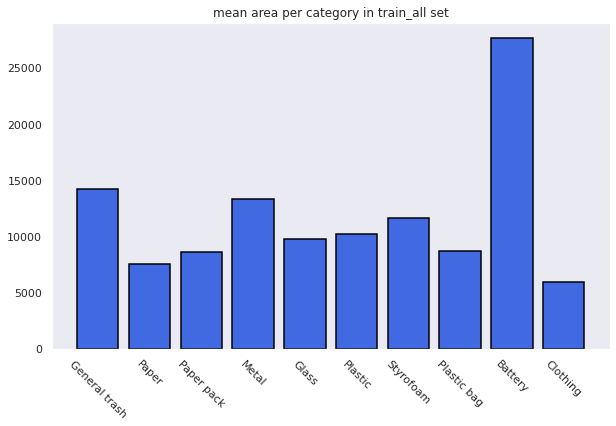

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(x=data['category_id'].value_counts().index, height=data['area'].groupby(data['category_id']).mean(),edgecolor='black',linewidth=1.5,color='royalblue')
ax.set_xticks([x for x in range(1,11)])
ax.set_xticklabels([category[x]['name'] for x in range(10)],rotation=-45)
ax.set_title("mean area per category in train_all set")
plt.show()

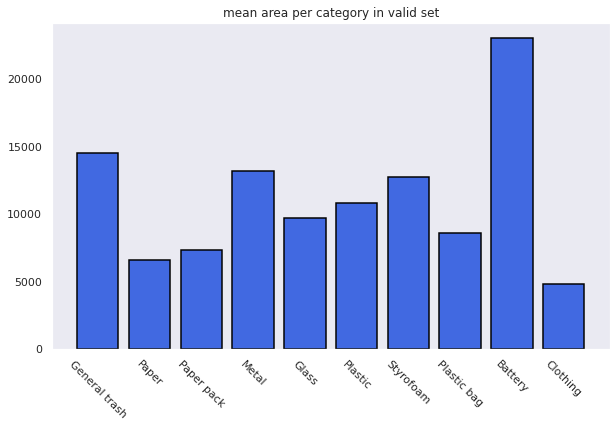

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(x=valid_data['category_id'].value_counts().index, height=valid_data['area'].groupby(valid_data['category_id']).mean(),edgecolor='black',linewidth=1.5,color='royalblue')
ax.set_xticks([x for x in range(1,11)])
ax.set_xticklabels([category[x]['name'] for x in range(10)],rotation=-45)
ax.set_title("mean area per category in valid set")
plt.show()

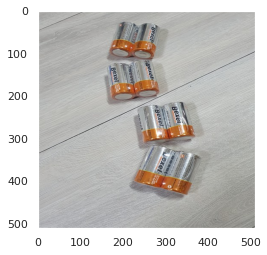

In [156]:
# 배터리 값이 높은 이유: 주로 배터리밖에 없는 확대된 사진이 대부분.
showimg(933,size=4)

In [ ]:
# area가 1인 경우
data[data['area']==1.0]

,image_id,category_id,area,num_seg
12529,1662.0,1.0,1.0,2.0
17852,2015.0,2.0,1.0,2.0


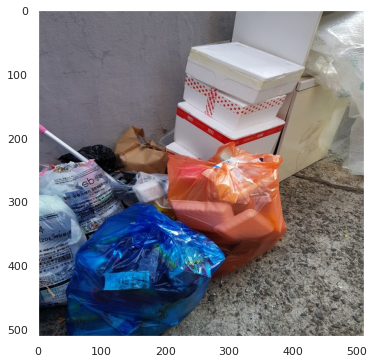

In [211]:
showimg(1662)

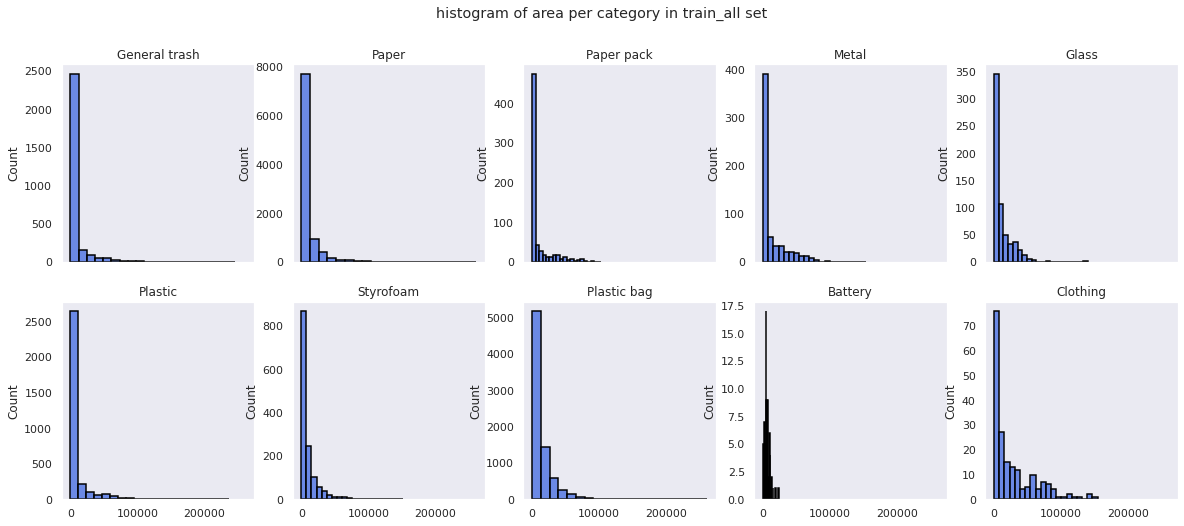

In [239]:
fig, axes = plt.subplots(2,5, figsize=(20, 8),sharex=True)
for i in range(2):
    for j in range(5):
        sns.histplot(data[data['category_id']==5*i+j+1]['area'],bins=20,edgecolor='black',linewidth=1.5,color='royalblue',ax=axes[i][j])
        axes[i][j].set_title(category[5*i+j]['name'])
        axes[i][j].set_xlabel(None)
fig.suptitle('histogram of area per category in train_all set')
plt.show()

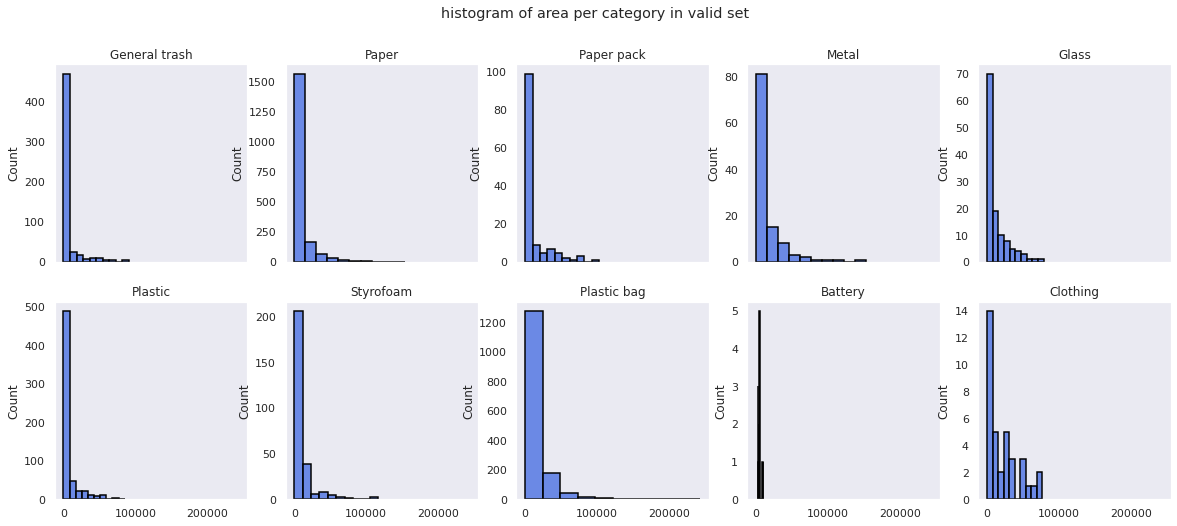

In [238]:
fig, axes = plt.subplots(2,5, figsize=(20, 8),sharex=True)
for i in range(2):
    for j in range(5):
        sns.histplot(valid_data[valid_data['category_id']==5*i+j+1]['area'],bins=10,edgecolor='black',linewidth=1.5,color='royalblue',ax=axes[i][j])
        axes[i][j].set_title(category[5*i+j]['name'])
        axes[i][j].set_xlabel(None)
fig.suptitle('histogram of area per category in valid set')
plt.show()

### 3. Annotation 시각화
같은 category라도 다른 object인 경우에는 다르게 annotation 되어있음.

하나의 object가 다른 물체에 겹쳐서 영역이 둘 이상인 경우 하나의 annotation 안에서 segmentation 정보를 여러 개로 구성. 

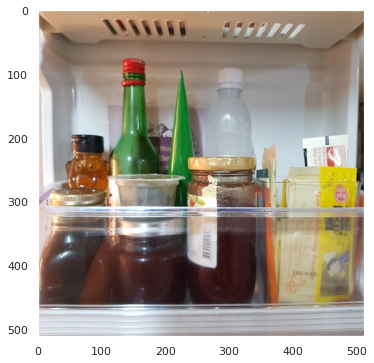

In [157]:
showimg(0)

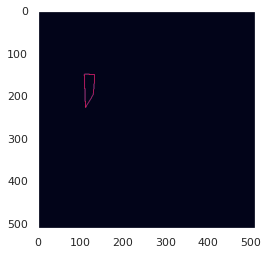

In [240]:
show_anno(0,0,showbox=False)

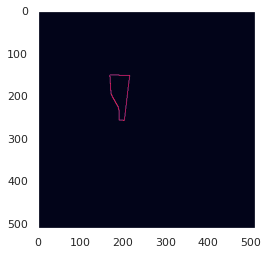

In [241]:
show_anno(0,1,showbox=False)

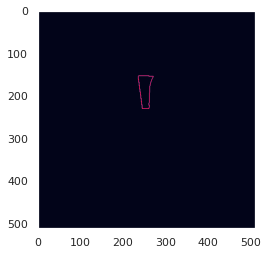

In [242]:
show_anno(0,2,showbox=False)

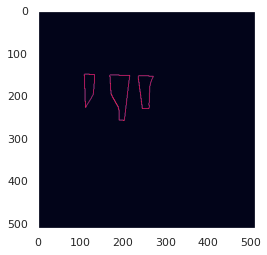

In [303]:
show_annos(0,showbox=False) # 하나의 object에 segmentation개수: 3, area:6307.5

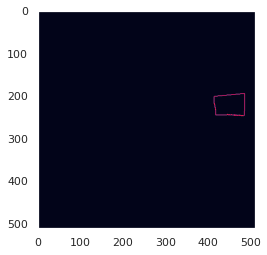

In [304]:
show_annos(1,showbox=False) # area:3313.5

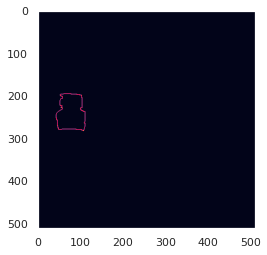

In [305]:
show_annos(2,showbox=False) # area:4741

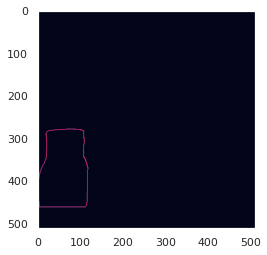

In [306]:
show_annos(3,showbox=False) # area:18560.5